In [42]:
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from IPython.display import Audio

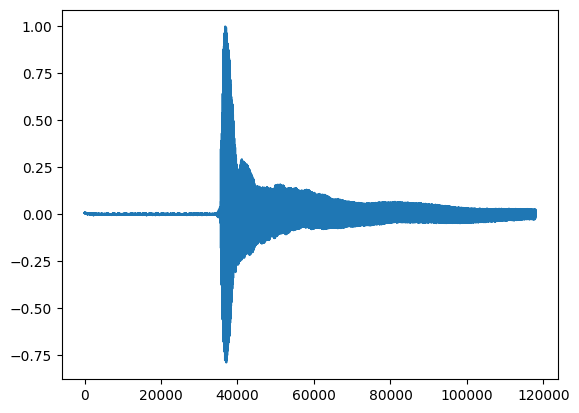

In [2]:
file_name = "string_2.wav"
rate, sig = wav.read(file_name)
sig = (sig - sig.mean()) / sig.max()
plt.plot(sig)
plt.show()

# FIR Delay effect

### Numpy Implementation

A very simple and efficient way to implement the FIR delay effect is to use vector operations with Numpy. First let's recall the formula seen in class.

$$
s[t] = e[t]+ \alpha e[t-D]
$$

Now this could be implemented in Numpy by simply using some zero paddings. Let's visualize how that would work for $t \in [1,n] $

<img src="fir.png" width="850"/>

In [20]:
%%time

# define delay in seconds
# delay_sec = 1  
# D = round(delay_sec*rate)

D = 10000

alpha = 0.5  # attenuation factor

padding = np.zeros(D)
padded_sig = np.concatenate([sig,padding])
delayed_sig = np.concatenate([padding,sig])

impulse_response_vector = padded_sig + alpha*delayed_sig
impulse_response_vector = impulse_response_vector[:sig.shape[0]]
assert impulse_response_vector.shape == sig.shape

CPU times: user 0 ns, sys: 2.71 ms, total: 2.71 ms
Wall time: 1.89 ms


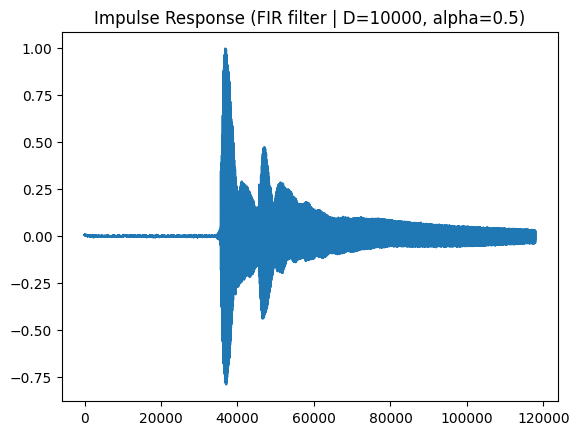

In [21]:
# plot new signal
plt.plot(impulse_response_vector)
plt.title(f'Impulse Response (FIR filter | D={D}, alpha={alpha})')
plt.show()

In [22]:
# play signal inside notebook
Audio(impulse_response_vector, rate=rate)

### Filter implementation

Let's go back to the original formula of an FIR filter 
$$
s[t] = \sum_{i=0}^{n-1}{b[i]e[t-i]} 
$$
such that b is the FIR coefficients. Now we open this formula and try to compute the vector b for our FIR delay effect:
$$
s[t] = b[0]e[t] + b[1]e[t-1] + ......... + b[D-1]e[t-(D-1)] + b[D]e[t-D]
$$
if we take $b[0]=1$, $ b[1:D-1]=0$, $b[D]=\alpha$, then we obtain 
$$
s[t] = 1 \times e[t] + 0 \times e[t-1] + ......... + 0 \times e[t-(D-1)] + \alpha \times e[t-D]
$$
$$
s[t] = e[t] + \alpha e[t-D] 
$$

Therefore, to create an FIR delay effect, we just have to take $b = [1, 0_1, ..., 0_{D-1}, \alpha]$

The built-in function **lfilter** of Scipy allows us to apply a discrete IIR filter to a signal. Since we have a discrete FIR filter, we'll simply set the array of denominator coefficients (the one of the recursive) to 1. 

In [24]:
%%time

b = np.concatenate([[1], np.zeros(D-1), [alpha]])
a = 1
impulse_response_filter = signal.lfilter(b, a, sig)

CPU times: user 1.46 s, sys: 5.4 s, total: 6.86 s
Wall time: 6.9 s


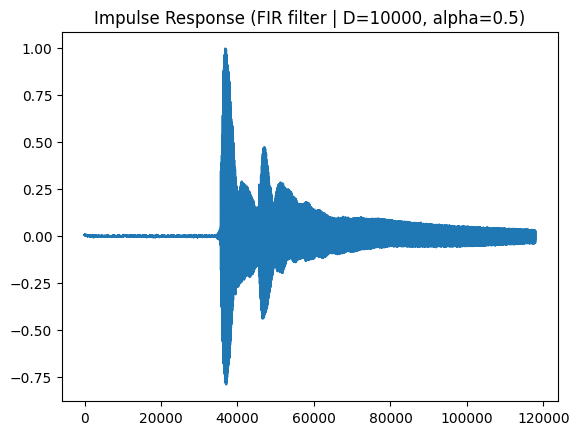

In [25]:
# plot new signal
plt.plot(impulse_response_filter)
plt.title(f'Impulse Response (FIR filter | D={D}, alpha={alpha})')
plt.show()

Check if the output is the same as in the previous implementation. Using inf norm of the signal difference.

In [26]:
np.linalg.norm(impulse_response_vector - impulse_response_filter, np.inf)

0.0

As expected, the impulse response is the same in both implementations. However, let's look back at the runtime of both methods:
* Numpy : 1.89 ms
* Filter : 6.9 s
We notice that the Numpy method is significantly faster than the second method. The difference in runtime between both methods increases as D gets bigger. This difference is mainly due to the use of vector operations in the first method which are much more efficient than using the built-in function lfilter designed to apply IIR filters, where vector operations can't be used because of the recursion (computation is much more difficult to be parallelized).

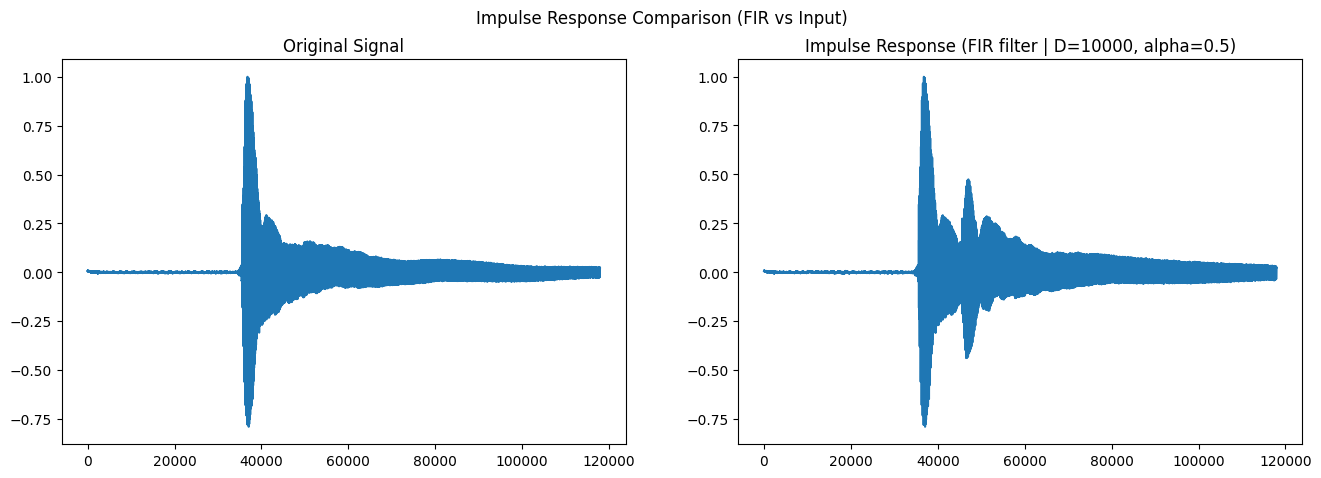

In [40]:
# plot impulse response side by side with the original signal
fig, ax = plt.subplots(1,2, figsize=(16,5))
ax[0].plot(sig)
ax[0].title.set_text(f'Original Signal')
ax[1].plot(impulse_response_filter)
ax[1].title.set_text(f'Impulse Response (FIR filter | D={D}, alpha={alpha})')
plt.suptitle(f'Impulse Response Comparison (FIR vs Input)')
plt.show()

### Frequency response
Plotting the frequency responce for D=1 

In [46]:
alpha = 0.5
D = 1

b = np.concatenate([[1], np.zeros(D-1), [alpha]])

# frequency response of filter (in dB)
w, h = signal.freqz(b)    # a=1 by default

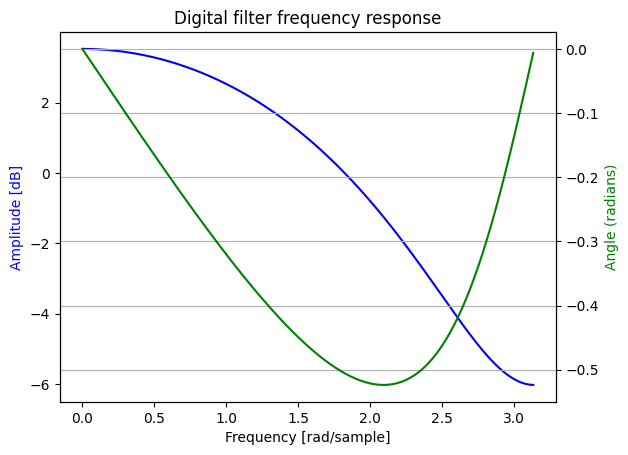

In [47]:
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')

ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid(True)
ax2.axis('tight')
plt.show()

# IIR Delay effect

### Cycle implementation
Our first implementation is a simple loop through the length of the input signal. 

In [ ]:
T = len(sig)
new_sig_cycle = sig.copy()

# define coefficients
alpha = 0.5
beta = 0.5
D = 10000

In [ ]:
# calculate first sample
new_sig_cycle[0] = alpha*sig[0];
# run the cycle
for t in range(1,T):
    if t-D >= 0:
        new_sig_cycle[t] = alpha*sig[t] + beta*new_sig_cycle[t-D]
    else:
        new_sig_cycle[t] = alpha*sig[t]



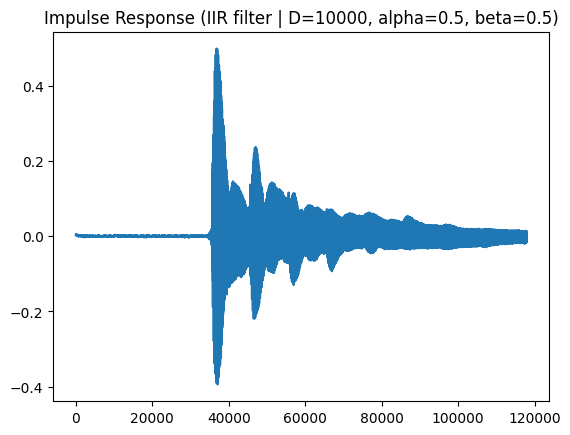

In [ ]:
# plot new signal
plt.plot(new_sig_cycle)
plt.title(f'Impulse Response (IIR filter | D={D}, alpha={alpha}, beta={beta})')
plt.show()

In [ ]:
# play signal inside notebook
Audio(new_sig_cycle, rate=rate)

### Filter implementation (z-transformation)
We can also implement the delay effect using a lfilter function (analog to filter in matlab). It takes b,a coeficients of z-transformed filter and the input signal. The coeficients are calculated next:

We have such definition of the delay effect:
$$s[t] = \alpha e[t] + \beta s[t-D]$$
We can transform this to z-domain:
$$ 
S(z) = \alpha E(z) + \beta z^{-D}S(z) 
$$ 
$$ 
S(z) = \frac{\alpha}{1-\beta z^{-D}}E(z)
$$

Coeficients b,a are nominator and denominator of the fraction in the vector form. Since we have no z in the nominator, and one $z^{-D}$ in the denominator, all other values in the vectors a,b will be zero:

b=[$\alpha$, 0, 0...]  
a=[1, 0, ...,0, -$\beta$]

Both a,b vectors of length D+1, where D is the delay in samples.

In [ ]:
b = [0] * (D+1)
b[0] = alpha


a = [0] * (D+1)
a[0] = 1
a[-1] = -beta

new_sig_filter = signal.lfilter(b, a, sig)

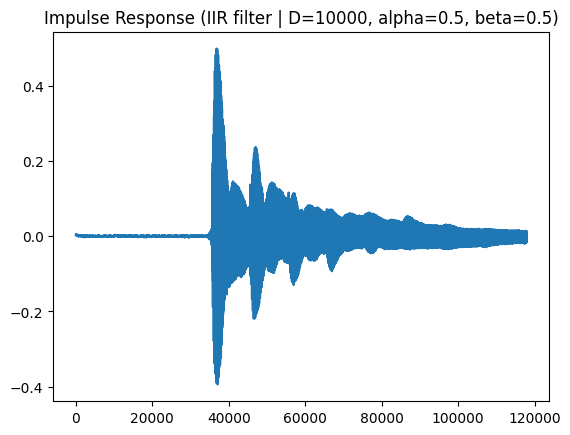

In [ ]:
# plot the signal response
plt.plot(new_sig_filter)
# title
plt.title(f'Impulse Response (IIR filter | D={D}, alpha={alpha}, beta={beta})')
plt.show()
plt.show()

Check if the output is the same as in the previous implementation. Using inf norm of the signal difference. 

In [ ]:
np.linalg.norm(new_sig_cycle - new_sig_filter, np.inf)

0.0

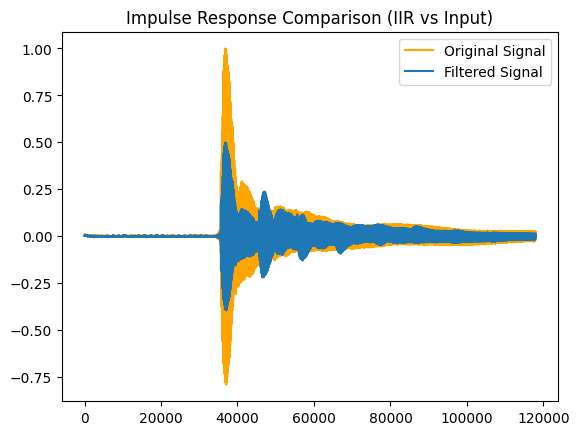

In [ ]:
# plot new signal on top of the original signal
plt.plot(sig, color='orange')
plt.plot(new_sig_filter)
# add legend
plt.legend(['Original Signal', 'Filtered Signal'])
plt.title(f'Impulse Response Comparison (IIR vs Input)')
plt.show()

### Frequency response
Plotting the frequency responce for D=1 

In [ ]:
alpha = 0.5
beta = 0.5
D = 1

b = [0] * (D+1)
b[0] = alpha


a = [0] * (D+1)
a[0] = 1
a[-1] = -beta

# frequency response of filter (in dB)
w, h = signal.freqz(b, a)

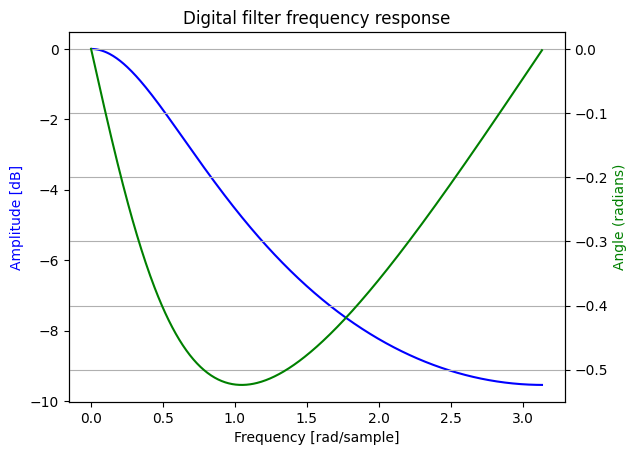

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')

ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid(True)
ax2.axis('tight')
plt.show()

### Is this implementation always stable ?
> yes  


Filter is stabel if: 
$$ |p| < 1 $$ 
where p is the pole(s) of the filter. We can find the pole(s) by finding when denomiator of z-transfomration is ==0:  
$$ 
A(z) = 1 - \beta z^{-D} = 0 
$$
$$ 
1 = \beta z^{-D} 
$$
$$ 
\frac{\beta}{z^{D}} = 1 
$$
$$ 
z = \sqrt[D]{\beta} 
$$
Give $\beta=0.5$ we have pole $p = \sqrt[D]{0.5} <1$ for all D>0, so the filter is stable.

### Discuss the parameters

So, the parameter D is the delay in samples. The parameter $\beta$ is the attenuation factor. The higher the value of $\beta$ the more the signal is attenuated. The parameter $\beta$ is also called the feedback coefficient. Basically, the higher the value of $\beta$ the more the the echos in the signal are faded out. 

Parameter $\alpha$ is the gain of the direct signal. The higher the value of $\alpha$ the more the direct signal is amplified. 

Example with big $\alpha$. We can see how original signal is amplified:

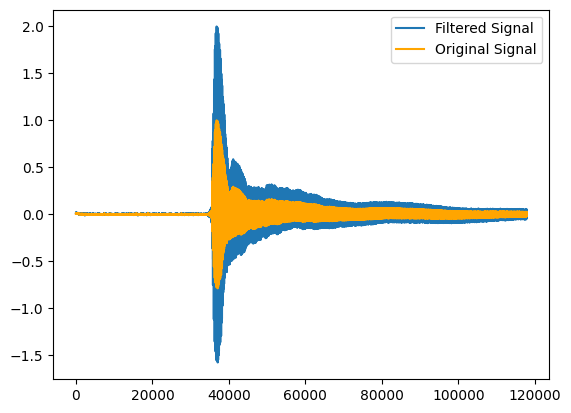

In [ ]:
alpha = 2.0
beta = 0.0
D=1
b = [0] * (D+1)
b[0] = alpha

a = [0] * (D+1)
a[0] = 1
a[-1] = -beta

new_sig_filter = signal.lfilter(b, a, sig)

# plot new signal on top of the original signal
plt.plot(new_sig_filter)
plt.plot(sig, color='orange')

# add legend
plt.legend(['Filtered Signal', 'Original Signal'])
plt.show()

Example with big $\beta=0.9$ (stable since $\sqrt[10000]{0.9} < 1$). We can see how the echos have big amplitude and are fading out veeery slowly:

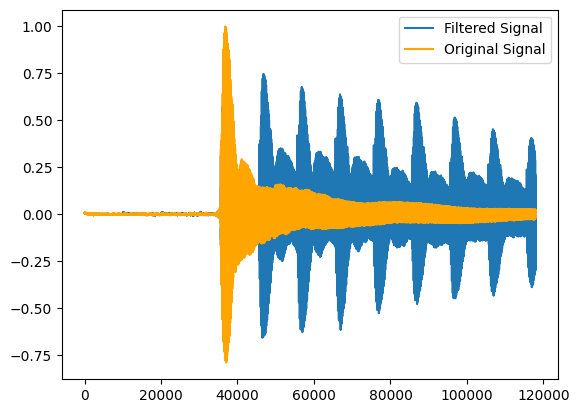

In [ ]:
alpha = 0.9
beta = 0.9
D=10000
b = [0] * (D+1)
b[0] = alpha

a = [0] * (D+1)
a[0] = 1
a[-1] = -beta

new_sig_filter = signal.lfilter(b, a, sig)

# plot new signal on top of the original signal
plt.plot(new_sig_filter)
plt.plot(sig, color='orange')

# add legend
plt.legend(['Filtered Signal', 'Original Signal'])
plt.show()

### Compare with the FIR implementation

The key difference between the FIR implementation and the IIR implementation is the recursive part that only appears in the IIR filter. This recursion makes parallelizing the computation of the impulse response of IIR filters much more difficult. This recursion can also be noticed in the impulse response as an echo where the note gets repeated several times until fading, whereas in the FIR response, the repeated note could only be heard one time after the delay. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=35d385fa-f727-49f4-8958-3616eec12d9d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>